<a href="https://colab.research.google.com/github/amura/deep-rl-robots/blob/main/Deep_RL_learning_robot_DQN_Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Rendering dependencies


In [1]:
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools > /dev/null 2>&1
!apt-get install swig > /dev/null 2>&1
#!pip install https://github.com/openai/gym/archive/refs/tags/0.18.1.tar.gz 
!pip install gym==0.17.1  > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install ez_setup > /dev/null 2>&1
#!pip install gym[atari] > /dev/null 2>&1
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* > /dev/null 2>&1



In [2]:
# show version in use
!pip show gym
#!pip install gym==0.18.1 --upgrade
#!pip install https://github.com/openai/gym/archive/refs/tags/0.18.1.tar.gz  --upgrade

Name: gym
Version: 0.17.1
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: cloudpickle, six, numpy, scipy, pyglet
Required-by: dopamine-rl


In [3]:
#!pip install gym[all] > /dev/null 2>&1
#!pip install Box2D /dev/null 2>&1

In [3]:
from pyvirtualdisplay import Display
import logging
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.DEBUG, format=FORMAT)

!echo $DISPLAY

_display = Display(visible=0, size=(1400, 900))
_display.start()

!echo $DISPLAY


2021-05-10 19:50:01,401 - easyprocess - DEBUG - command: ['Xvfb', '-help']
2021-05-10 19:50:01,414 - easyprocess - DEBUG - process was started (pid=1663)
2021-05-10 19:50:01,442 - easyprocess - DEBUG - process has ended, return code=0
2021-05-10 19:50:01,445 - easyprocess - DEBUG - command: ['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1000']
2021-05-10 19:50:01,447 - easyprocess - DEBUG - command: ['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001']
2021-05-10 19:50:01,462 - easyprocess - DEBUG - process was started (pid=1664)
2021-05-10 19:50:01,464 - pyvirtualdisplay.abstractdisplay - DEBUG - DISPLAY=:1001
2021-05-10 19:50:01,466 - easyprocess - DEBUG - command: ['xdpyinfo']
2021-05-10 19:50:01,481 - easyprocess - DEBUG - process was started (pid=1665)
2021-05-10 19:50:02,139 - easyprocess - DEBUG - process has ended, return code=0
2021-05-10 19:50:02,142 - pyvirtualdisplay.abstractdisplay - INFO - Successfully started X with display ":1

:1001


In [4]:
import io
import os
import base64
from IPython.display import HTML, display as disp
def show_video(path):
    if not os.path.isfile(path):
        raise NameError("Cannot access{}".format(path))
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    disp(HTML(data="""<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4"/></video> """.format(encoded.decode('ascii'))))


In [6]:
# import io
# import os
# import base64
# from IPython.display import HTML, display as disp

# print(env.file_infix)
# show_video('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix)


In [6]:
# Import required libraries
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

random.seed(10) # For repeatability

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [7]:
# Import and setup gym environment
import gym
from gym.envs.box2d import car_racing
from gym import logger as gymlogger
from gym import wrappers

gymlogger.setLevel(gymlogger.MIN_LEVEL)


env = gym.make('CarRacing-v0').unwrapped
env = wrappers.Monitor(env,"./gym-results", force=True)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
# Action space - discretise

# Turn_left	
# [ -1.0, 0.0, 0.0 ]
# Turn_right	
# [ +1.0, 0.0, 0.0 ]
# Brake	
# [ 0.0, 0.0, 0.8 ]
# Accelerate	
# [ 0.0, 1.0, 0.8 ]
# Do-Nothing	
# [ 0.0, 0.0, 0.0 ]

ACTIONS = [[ -1.0, 0.0, 0.0 ], [ +1.0, 0.0, 0.0 ], [ 0.0, 0.0, 0.8 ], [ 0.0, 1.0, 0.0 ], [ 0.0, 0.0, 0.0 ]]
NUM_ACTIONS = len(ACTIONS)




### Utilities for image extraction and processing from environment


In [9]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]

    #view_width = int(screen_width * 0.6)      
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, screen_width//3:2*screen_width//3]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)





/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Track generation: 987..1238 -> 251-tiles track


2021-05-10 14:28:34,161 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2021-05-10 14:28:34,167 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2021-05-10 14:28:34,170 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2021-05-10 14:28:34,173 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-10 14:28:34,175 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2021-05-10 14:28:34,177 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2021-05-10 14:28:34,178 - matplotlib.font_manager - DEBUG - findfont: scor

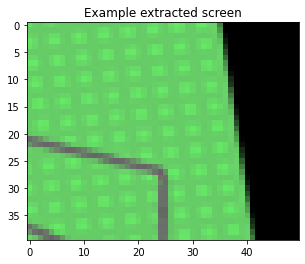

In [11]:
# Show example
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

Deep Q network

    Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing Q(s, \mathrm{left})Q(s,left) and Q(s, \mathrm{right})Q(s,right) (where ss is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.


In [10]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
    # Allows selection of random batch of transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Hyperparameters


*   select_action: According to epsilon greedy policy. Random selection starts at prop EPS_START, decays exponentially down to EPS_END, EPS_DECAY rate of decay
*   plot_durations: plots durations of episodes, and average over the last 100 episodes



In [12]:
# Hyper parameters
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

env.reset()
# screen dimensions obtained to get the required shapesf for initialising layers
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

print(f'Screen height {screen_height}')
print(f'Screen width {screen_width}')

# Get number of actions from gym action space
n_actions = NUM_ACTIONS
# pass in h, w, num actions as the outputs
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())

memory = ReplayMemory(10000)

steps_done = 0

# Epsilon-greedy for action selection
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
episode_returns = []

def plot_returns():
    plt.pause(0.01)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
    plt.figure(2)
    plt.clf()
    returns = torch.tensor(episode_returns, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Returns')
    plt.plot(returns.numpy(), label='Returns')
    if len(returns) >= 10:
        means = returns.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy(), label='10-episode-mean returns')
    plt.legend()

Track generation: 1189..1490 -> 301-tiles track
Screen height 40
Screen width 50




*   Transition: Named tuple mapping (state, action) -> (next_state, reward)
*   ReplayMemory: cyclic buffer holding transitions observed recently



In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
# wait until env zooms to car
def wait_for_zoom():
    for x in range(0, 50):
        env.step([0, 0, 0])

In [16]:
env.close()

Complete


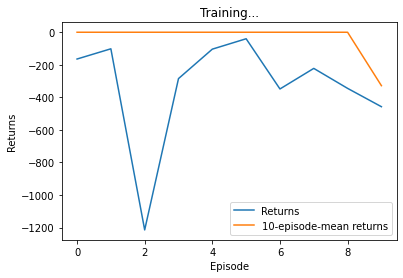

In [17]:
import time

num_episodes = 10
#env._max_episode_steps = 500



for i_episode in range(num_episodes):
    env.reset()
    wait_for_zoom()
    rewards_in_episode = 0
    print('Episode: '+str(i_episode))
    # Initialize the environment and state
    last_screen = get_screen()
    # following accelerates
    _, reward, done, _ = env.step([0,1,0])
    current_screen = get_screen()
    state = current_screen - last_screen
    print(f'Starting state {state}')
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(ACTIONS[action.item()])
        rewards_in_episode = rewards_in_episode + reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # periodically save the state's screenshot along with the numerical values in an easy to read way:
        if t % 500 == 0:
            print(f'Last action performed {action}')
            fname = './gym-results/screen-' + str(t) + '-' + str(int(time.time())) + '.jpg'
            st = env.render(mode="rgb_array")
            im = Image.fromarray(st)
            im.save(fname)
            st.tofile(fname + '.txt', sep=" ")
            #st.tofile(fname + '.input.txt', sep=" ")

        # Perform one step of the optimization
        optimize_model()
        if done:
            episode_returns.append(rewards_in_episode)
            plot_durations()
            print('Episode returns: ' + str(rewards_in_episode))
            torch.save(policy_net.state_dict(), './policy_net')
            if i_episode == (num_episodes - 1):
              plot_returns()
            break
    else:
      env.stats_recorder.save_complete()
      env.stats_recorder.done = True
    if i_episode % TARGET_UPDATE == 0:
      target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [13]:
loaded_policy_net = DQN(screen_height, screen_width, n_actions).to(device)
loaded_policy_net.load_state_dict(torch.load('./policy_net'))
loaded_policy_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=192, out_features=5, bias=True)
)

In [16]:
from gym import wrappers

done = False
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
wait_for_zoom()
last_screen = get_screen()

# Push the car forward so that current screen and last screen are not equal
env.step([0, 1, 0])

current_screen = get_screen()
state = current_screen - last_screen

while not done:
    with torch.no_grad():

      _, reward, done, _ = env.step(ACTIONS[loaded_policy_net(state).max(1)[1].view(1, 1).item()])

    reward = torch.tensor([reward], device=device)

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # Move to the next state
    state = next_state
    if done: break
env.close()

Track generation: 1300..1629 -> 329-tiles track


In [19]:
print(env.file_infix)
show_video('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix)

2.59


In [ ]:
env.close()